In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib

from matplotlib import pyplot as plt

import matplotlib.colors as mcolors

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.pyplot.rc('font', **font)






In [2]:
from jetset.plot_sedfit import PlotSED
from jetset.jet_model import Jet

In [16]:
j=Jet(electron_distribution='lppl')
j.show_model()


-------------------------------------------------------------------------------------------------------------------
jet model description
-------------------------------------------------------------------------------------------------------------------
name: tests  

electron distribution:
 type: lppl  
 electron energy grid size:  1001
 gmin grid : 2.000000e+00
 gmax grid : 1.000000e+06
 normalization  True
 log-values  False

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  50
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: on
   name:Sync, state: self-abs
   name:SSC, state: on
external fields transformation method: blob

SED info:
 nu grid size :200
 nu mix (Hz): 1.000000e+06
 nu max (Hz): 1.000000e+30

flux plot lower bound   :  1.000000e-30

      name             par type           units             val         phys. bound. min  phys. bound. max   log  frozen
---------------- ------------------- --------------- 

# Changing $\gamma_{min}$

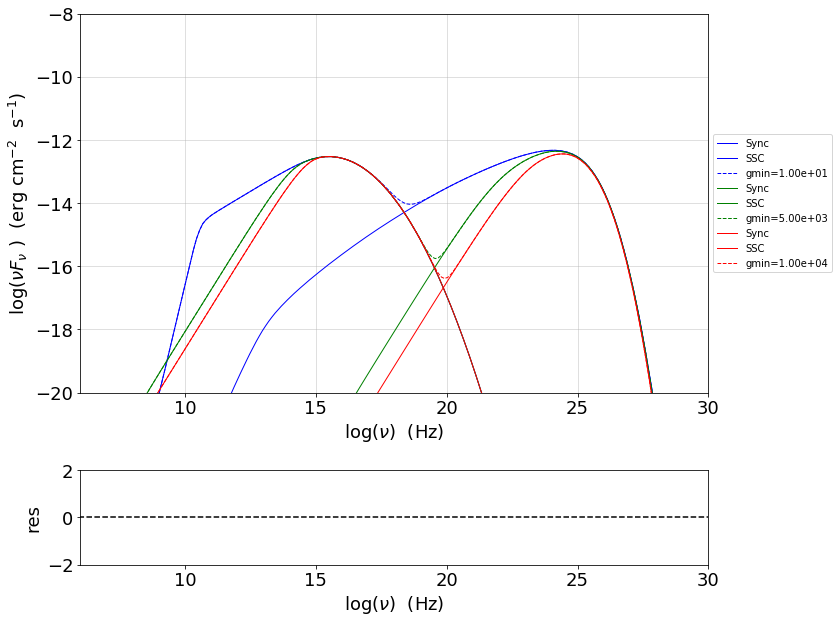

In [20]:


colors=list(mcolors.BASE_COLORS)


matplotlib.rc('font', **font)
p=PlotSED(figsize=(12,9))

j.parameters.gmax.val=1E8
j.parameters.r.val=1.0


for ID,gmin in enumerate([10,5000,10000]):
   
    j.set_gamma_grid_size(200)
    j.set_IC_nu_size(100)
    j.parameters.gmin.val=gmin
    j.set_N_from_nuFnu(nu_obs=1E17,nuFnu_obs=1E-13)
    j.eval()
    j.plot_model(p,label='gmin=%2.2e'%gmin,color=colors[ID])


# Changing the turn-over energy

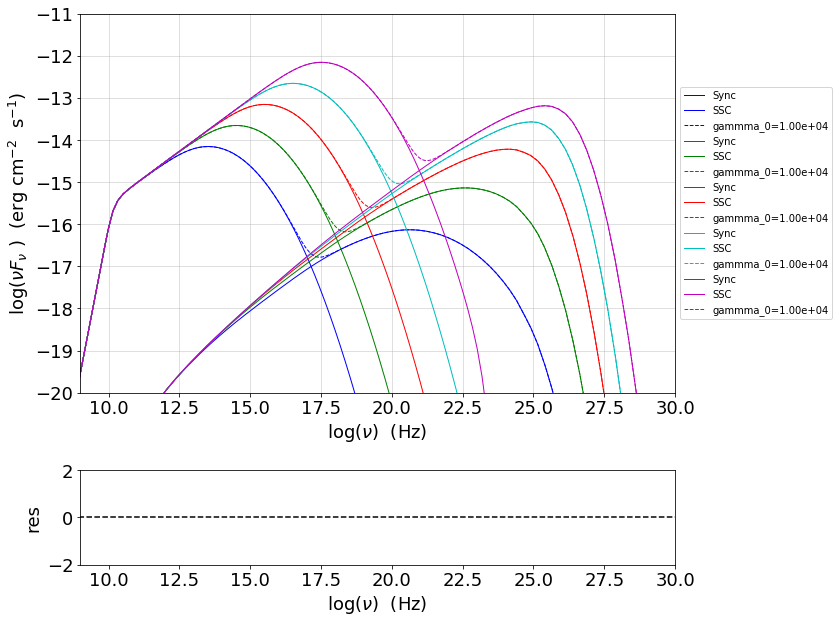

In [5]:
j=Jet(electron_distribution='lppl')

matplotlib.rc('font', **font)
p=PlotSED(figsize=(12,9))

j.parameters.gmax.val=1E8
j.parameters.r.val=1.0
j.parameters.s.val=2.0
j.parameters.N.val=500
j.parameters.z_cosm.val=0.05
for ID,gamma0_log_parab in enumerate(np.logspace(3,5,5)):
   
    j.set_nu_grid_size(1000)
    j.set_gamma_grid_size(200)
    j.set_IC_nu_size(100)
    j.parameters.gamma0_log_parab.val=gamma0_log_parab
    j.eval()
    j.plot_model(p,label='gammma_0=%2.2e'%gmin,color=colors[ID])

p.rescale(y_min=-20,y_max=-11,x_min=9)

# Changing the curvature in the high-enegy branch of the emitters

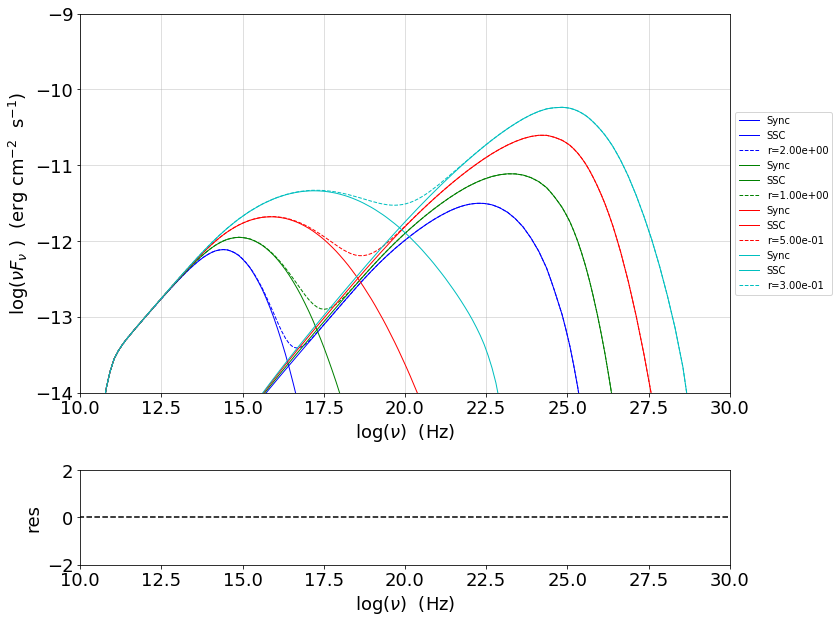

In [6]:
j=Jet(electron_distribution='lppl')

matplotlib.rc('font', **font)
p=PlotSED(figsize=(12,9))

j.parameters.gmax.val=1E8
j.parameters.gamma0_log_parab.val=5E3
j.nu_max=1E30

for ID,r in enumerate([2.0,1.0,0.5,0.3]):
   
    j.set_gamma_grid_size(200)
    j.set_IC_nu_size(100)
    j.parameters.r.val=r
    j.set_N_from_nuFnu(nu_obs=1E10,nuFnu_obs=1E-14)
    j.eval()
    j.plot_model(p,label='r=%2.2e'%r,color=colors[ID])
p.rescale(y_min=-14,y_max=-9,x_min=10)

# Transition from TH to KN regime for the IC emission

In [7]:
from jetset.poly_fit import do_log_Parab_FIT

def get_gamma_3p(j):
    #j.set_gamma_grid_size(1000)
    j.electron_distribution.update()
    
    x=np.log10(j.electron_distribution.gamma)
    y=np.log10(j.electron_distribution.n_gamma)+3*x
    y_p=y.max()
    x_p=x[np.argmax(y)]
    p,err=do_log_Parab_FIT(x,y,x_p,y_p,-1,x_range=[x_p-0.5,x_p+0.5],dy=np.ones(x.size))
    return p

def get_log_par_peak(x_p,y_p,j,comp):
    c=j.get_spectral_component_by_name(comp)
    x=np.log10(c.SED.nu.value)
    y=np.log10(c.SED.nuFnu.value)
    
    p,err=do_log_Parab_FIT(x,y,x_p,y_p,-0.1,x_range=[x_p-1,x_p+1],dy=np.ones(x.size))
    p,err=do_log_Parab_FIT(x,y,p[0],p[1],p[2],x_range=[p[0]-1,p[0]+1],dy=np.ones(x.size))
   
    return p,err

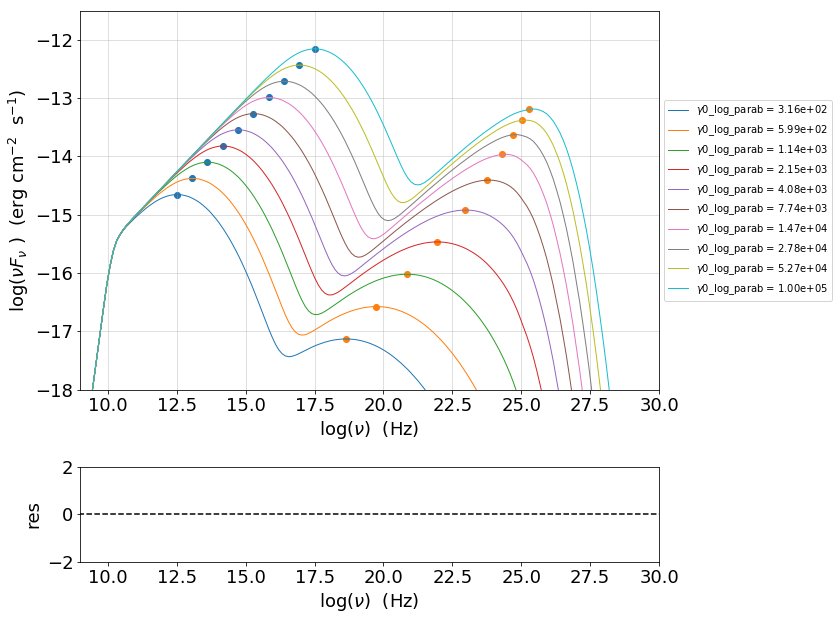

In [8]:
    
j=Jet(electron_distribution='lppl')

matplotlib.rc('font', **font)
p=PlotSED(figsize=(12,9))

size=10

j.parameters.gmax.val=1E8
j.parameters.r.val=1.0
j.parameters.s.val=2.0
j.parameters.N.val=500
j.parameters.z_cosm.val=0.05

nu_p_S=np.zeros(size)
nu_p_IC=np.zeros(size)
nuFnu_p_S=np.zeros(size)
nuFnu_p_IC=np.zeros(size)
r_S=np.zeros(size)
r_S_err=np.zeros(size)
r_IC=np.zeros(size)
r_IC_err=np.zeros(size)
g_p_e=np.zeros(size)
n3g_p_e=np.zeros(size)

#colors=list(mcolors.CSS4_COLORS)


for ID,gamma0_log_parab in enumerate(np.logspace(2.5,5,size)):
   
    j.set_nu_grid_size(200)
    j.set_gamma_grid_size(200)
    j.set_IC_nu_size(200)
    j.parameters.gamma0_log_parab.val=gamma0_log_parab
    j.eval()
    j.plot_model(p,comp='Sum',label='$\gamma0$_log_parab = %2.2e'%gamma0_log_parab)
    #with log_log=True, the values are already logarthmic
    x_p,y_p=j.get_component_peak('Sync',log_log=True)
    (nu_p_S[ID],nuFnu_p_S[ID],r_S[ID]),err=get_log_par_peak(x_p,y_p,j,'Sync')
    r_S_err[ID]=err[2]
    
    x_p,y_p=j.get_component_peak('SSC',log_log=True)
    (nu_p_IC[ID],nuFnu_p_IC[ID],r_IC[ID]),err=get_log_par_peak(x_p,y_p,j,'SSC')
    r_IC_err[ID]=err[2]
    g_p_e[ID],n3g_p_e[ID],_=get_gamma_3p(j)
    
p.rescale(y_min=-18,y_max=-11.5,x_min=9)

p.sedplot.scatter(nu_p_S,nuFnu_p_S)
p.sedplot.scatter(nu_p_IC,nuFnu_p_IC)


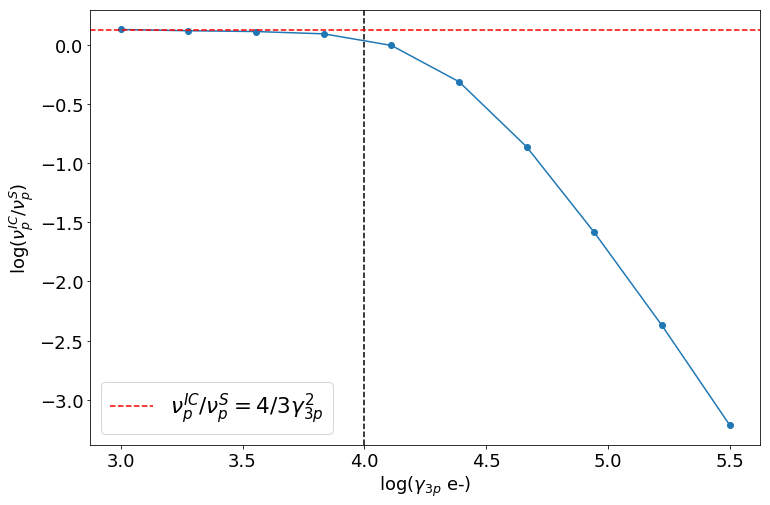

In [9]:
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(12,8))

ax=fig.add_subplot(111)
ax.plot(g_p_e,(nu_p_IC-nu_p_S)-2*g_p_e,'-o')
ax.set_ylabel(r'log($ \nu_p^{IC} / \nu_p^{S} $)''')
ax.set_xlabel(r'log($\gamma_{3p}$ e-)')
ax.axvline(4.0,ls='--',c='black')
ax.axhline(np.log10(4/3),ls='--',c='red',label=r"$ \nu_p^{IC} / \nu_p^{S} =4/3 \gamma_{3p}^2$")
ax.legend(fontsize='large',loc='lower left')

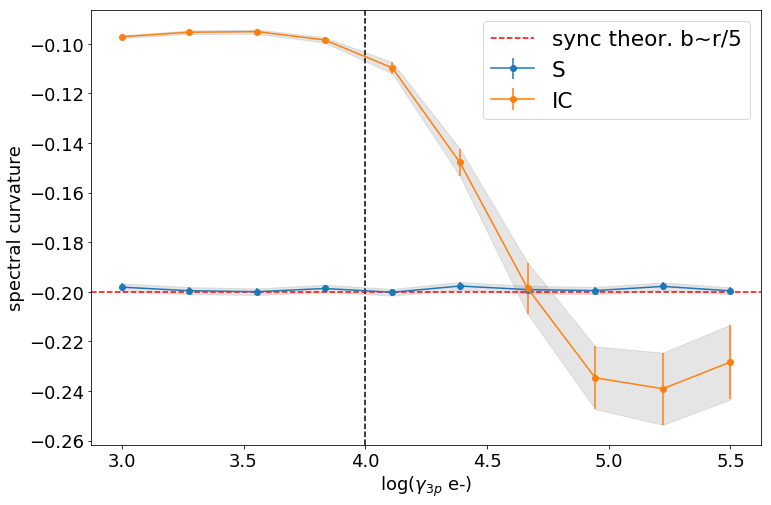

In [21]:
fig = plt.figure(figsize=(12,8))

ax=fig.add_subplot(111)
ax.errorbar(g_p_e,r_S,yerr=r_S_err,fmt='-o',label='S')
ax.fill_between(g_p_e, r_S - r_S_err, r_S + r_S_err,
                 color='gray', alpha=0.2)
ax.errorbar(g_p_e,r_IC,yerr=r_IC_err,fmt='-o',label='IC')
ax.fill_between(g_p_e, r_IC - r_IC_err, r_IC + r_IC_err,
                 color='gray', alpha=0.2)
ax.set_ylabel('spectral curvature')
ax.set_xlabel(r'log($\gamma_{3p}$ e-)')
ax.axvline(4.0,ls='--',c='black')
ax.axhline(-0.2,ls='--',c='red',label='sync theor. b~r/5')
ax.legend(fontsize='large')

# Exercise
derive the trend for the Compton dominance (CD) as a function of N a gamma0_log_parab

hint: use the get_component_peak to extract the peak of the SED for each component